In [4]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.multiclass import OneVsOneClassifier
from tabulate import tabulate 
from sklearn.externals import joblib 
import joblib as job
import pickle as pk

class LogRegression(object):
    
    # Utility Functions
    def __init__(self, arg):
        super(LogRegression, self).__init__()
        self.arg = arg
        self.multi=None
        

    def accuracy(self,actual,predicted):
    
      c = 0
      for i in range(len(actual)):
          if(actual[i]!=predicted[i]):
              continue
          else:    
              c = c + 1
      return c/len(actual)

    def Classwise_Accuracy(self,Ypred,Yact):

      C = np.array(Yact)
      C = list(np.unique(C))
      C.sort()
      
      Main_Acc = []
      for i in range(len(C)):
        Pred = []
        Act = []
        for j in range(len(Ypred)):
          if(Yact[j]==C[i]):
            Pred.append(Ypred[j])
            Act.append(Yact[j])
        Main_Acc.append(self.accuracy(Act,Pred))
      return Main_Acc      
    
    def NfoldSplit(self,Data,n):
       
      NewData = []
      #Data1 = Data.sample(frac = 1 , random_state = 1)
      size = (Data.shape[0]//n)+1
      for i in range(n):
        T = Data[i*size:i*size+size]
        NewData.append(T)
      return NewData

    def Load_DataSet(self,arg):
      
      Data = loadmat(self.arg[0])
      Data_label = Data['labels']
      Data_label = Data_label.reshape(Data_label.shape[1],1)
      Data_sample = Data['samples']
      Data = np.hstack((Data_sample,Data_label))
      return Data

    def Loss(self,Ypred,Yact):   # Some problem

      h1 = np.log(Ypred)
      h2 = np.log(1 - Ypred)
      C1 = Yact*h1
      C2 = (1-Yact)*h2
      C = C1 + C2
      C = (-1/Ypred.shape[0])*np.sum(C)
      return C

    def plot(self,Res_Main):
      print('\t\tCurves representing Training statistics and Validation statistics.')
      for i in range(len(Res_Main)):
        Res = Res_Main[i]
        plt.figure(figsize=(10,5))
        plt.title('Fold '+str(i+1)+' : Epoch vs Training Accuracy/Validation Accuracy')
        plt.plot(list(Res['Epoch']),list(Res['Training Accuracy']),label='Training Accuracy')
        plt.plot(list(Res['Epoch']),list(Res['Validation Accuracy']),label = 'Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Training Accuracy/Validation Accuracy')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,5))
        plt.title('Fold '+str(i+1)+' : Epoch vs Training Loss /Validation Loss')
        plt.plot(list(Res['Epoch']),list(Res['Training Loss']),label='Training Accuracy')
        plt.plot(list(Res['Epoch']),list(Res['Validation Loss']),label = 'Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss /Validation Loss')
        plt.legend()
        plt.show()

    def Hypothesis(self,x,w,b):
    
      h = np.sum(x[:2]*w) + b
      try :
        h = 1/(math.exp(-h) + 1)
      except :
        h = 0.5
      return h

    def DerivateFactor(self,Data,w,b,D):  # Takes the whole data with label and features

      l = 0  
      for i in range(Data.shape[0]):
        t = self.Hypothesis(Data[i],w,b) - Data[i][2] 
        if D==2:
          t = t
        else:  
          t = t*Data[i][D]
        l = l + t
      return l

    def predict(self,X_test):
        
        w = arg[4]
        if self.multi ==True:
          y = []
          y_predicted = np.dot(X_test,w.T)
          y_predicted = 1/(np.exp(-y_predicted) + 1)
          for i in range(y_predicted.shape[0]):   
            y.append(np.argmax(y_predicted[i,:]))
          y_predicted = np.array(y) 
        else:
          b = arg[5]
          h = X_test*w
          h = np.sum(h,axis=1)
          h = h + b
          h = np.exp(-h) + 1
          h = 1/h
          y_predicted = h
        return y_predicted


    # 2(a) , 3(a)
    def Scatter_plot(self,arg):
    
      Data = self.Load_DataSet(arg)     
      Data = pd.DataFrame(Data, columns =['D1','D2','Label'])
      plt.figure(figsize=(10,5))
      sn.set(style = 'whitegrid')
      sn.scatterplot(data = Data ,x='D1',y='D2',hue='Label')
      plt.show()      

    #2(c)      
    def fit(self,arg,reg = None ,method = None,plot=False,print_table=False,print_class=False,ret=False):
      
      lr = arg[3]
      epochs = arg[2]
      split = arg[1]

      Data = self.Load_DataSet(arg)
      Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
      NewData = self.NfoldSplit(Data,arg[1])  
      NewData_C = NewData.copy()
      Main_Table = pd.DataFrame()
      
      if method == None:
        
        Result =[]   # To hold individual epochs data
        Res_Main = [] # To hold Data per fold
        Table = []


        for i in range(split):   # For folds
          
          w = np.array([0.5 , 0.5])
          b = 0.1
          for j in range(epochs):  # For epochs 

            NewData = NewData_C.copy()  
            Test = NewData.pop(i)
            Train = pd.concat(NewData) 
            Train = Train.to_numpy()
            Test = Test.to_numpy()
        
            D1 = self.DerivateFactor(Train,w,b,0)
            D2 = self.DerivateFactor(Train,w,b,1)
            D3 = self.DerivateFactor(Train,w,b,2)

            if reg==None:
              w[0] = w[0] - lr*D1
              w[1] = w[1] - lr*D2
              b = b - lr*D3
              path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/2_c/'+str(i)+str(j)
              path1 = str(path+'w.pkl')
              path2 = str(path+'b.pkl')
              pk.dump(w, open(path1, "wb"))
              pk.dump(b, open(path2, "wb"))
              #np.save(, w,allow_pickle=True)
              #np.save(path+'b', b,allow_pickle=True) 
            else :
              w[0] = w[0] - lr*D1 - (2*reg*w[0]/Train.shape[0])
              w[1] = w[1] - lr*D2 - (2*reg*w[1]/Train.shape[0])
              b = b - lr*D3 - (2*reg*b/Train.shape[0])
              path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/2_d/reg='+str(reg)+str(i)+str(j)
              path1 = str(path+'w.pkl')
              path2 = str(path+'b.pkl')
              pk.dump(w, open(path1, "wb"))
              pk.dump(b, open(path2, "wb"))
              #np.save(path+'w', w,allow_pickle=True)
              #np.save(path+'b', b,allow_pickle=True)               
            
            arg[4] = w
            arg[5] = b

            p = j+1

            Train_Pred = self.predict(Train[:,:2])
            Train_Pre = np.where(Train_Pred>0.5,1,0) 
            q = self.accuracy(list(Train[:,2]),list(Train_Pre))
            r = self.Loss(Train_Pred,Train[:,2])
        
            Test_Pred = self.predict(Test[:,:2])
            Test_Pre = np.where(Test_Pred>0.5,1,0) 
            s = self.accuracy(list(Test[:,2]),list(Test_Pre))
            t = self.Loss(Test_Pred,Test[:,2])
            Result.append([p,q,r,s,t])
        
          column = ['Epoch','Training Accuracy','Training Loss','Validation Accuracy', 'Validation Loss']
          Res = pd.DataFrame(Result, columns =column)
          T  =  Result[len(Result)-1]
          Table.append(T[1:])
          Result.clear()
          Res_Main.append(Res)
        
        Main_Table = pd.DataFrame(Table,columns = column[1:])
        Main_Table['Fold'] = [i+1 for i in range(split)]  
        
      elif method=='ovo':

        Result =[]   # To hold individual epochs data
        Res_Main = [] # To hold Data per fold

        Data = self.Load_DataSet(arg)
        Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
        
        C = list(Data.Label.unique())
        C.sort()
        Label = list(Data['Label'])
        Data['Label'] = Label

        NewData = self.NfoldSplit(Data,arg[1])  
        NewData_C = NewData.copy()
        ClTr = []
        ClTe = []
        
        for i in range(split):   # For folds

          NewData = NewData_C.copy()  
          Test = NewData.pop(i)
          Train = pd.concat(NewData) 
          
          Train = Train.to_numpy().astype(float)
          Test = Test.to_numpy().astype(float)

          Test_Model = []
          Train_Model = []
          
          Class_Com  = []
          
          for p in range(len(C)-1):    # Treat the classifier of p
            for q in range(p+1,len(C)):
              Class_Com.append(str(int(C[p]))+str(int(C[q])))

          for p in range(len(C)-1):    # Treat the classifier of p
            for q in range(p+1,len(C)):
              
              Train_p = Train[np.logical_or(Train[:,2]==C[p] ,Train[:,2]==C[q])]
              NewTrain =  Train_p
              NewTrain[:,2] =  np.where(NewTrain[:,2]==C[p],1,0)# Treat the classifier of p (Probability of p)

              w = np.array([0.5 , 0.5])
              b = 0.5

              for j in range(epochs):  # For epochs 

            
                D1 = self.DerivateFactor(NewTrain,w,b,0)
                D2 = self.DerivateFactor(NewTrain,w,b,1)
                D3 = self.DerivateFactor(NewTrain,w,b,2)

                w[0] = w[0] - lr*D1 - (2*reg*w[0]/NewTrain.shape[0])
                w[1] = w[1] - lr*D2 - (2*reg*w[1]/NewTrain.shape[0])
                b = b - lr*D3 - (2*reg*b/NewTrain.shape[0]) 


              path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/3_b/'+str(i)+str(p)+str(q)
              np.save(path+'w', w,allow_pickle=True)
              np.save(path+'b', b,allow_pickle=True)

              self.multi = False
              arg[4] = w
              arg[5] = b

              Train_Pred = self.predict(Train[:,:2])
              Train_Model.append(Train_Pred)

              Test_Pred = self.predict(Test[:,:2])
              Test_Model.append(Test_Pred)


          Train_Pred_Fold = pd.DataFrame()
          Test_Pred_Fold = pd.DataFrame()
          for e in range(len(Class_Com)):
            Train_Pred_Fold[Class_Com[e]] = Train_Model[e]
            Test_Pred_Fold[Class_Com[e]] = Test_Model[e]
        
          l = i+1
          
          u,v = list(Train_Pred_Fold.max(axis = 1)) , list(Train_Pred_Fold.idxmax(axis = 1))
          tr = [] 
          
          for h in range(len(u)):
            c1 = v[h]
            c1 = list(c1)
            if(u[h]>0.5):
              tr.append(int(c1[0]))
            else:
              tr.append(int(c1[1]))  

          u,v = list(Test_Pred_Fold.max(axis = 1)) , list(Test_Pred_Fold.idxmax(axis = 1))
          te = [] 
          for h in range(len(u)):
            c1 = v[h]
            c1 = list(c1)
            if(u[h]>0.5):
              te.append(int(c1[0]))
            else:
              te.append(int(c1[1]))     

          ClTr.append([i+1]+ self.Classwise_Accuracy(list(tr) , list(Train[:,2])))    
          ClTe.append([i+1]+ self.Classwise_Accuracy(list(te) , list(Test[:,2])))

          vx = self.accuracy(list(Train[:,2]),list(tr))
          mx = self.accuracy(list(Test[:,2]),list(te))

          Result.append([l,vx,mx])

        Main_Table = pd.DataFrame(Result, columns=['Fold','Training Accuracy','Testing Accuracy'])
        col = ['Fold'] + C 
        Class_Train = pd.DataFrame(ClTr,columns=col)
        Class_Test = pd.DataFrame(ClTe,columns=col)

      elif method=='ovr':

        Result =[]   # To hold individual epochs data
        Res_Main = [] # To hold Data per fold
        Table = []

        Data = self.Load_DataSet(arg)
        Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
        C = list(Data.Label.unique())
        Label = list(Data['Label'])
        Data = pd.get_dummies(Data, columns= ['Label'],prefix_sep='' , prefix='')
        Data['D0'] = 1
        Data['Label'] = Label

        NewData = self.NfoldSplit(Data,arg[1])  
        NewData_C = NewData.copy()
        X = ['D0','D1','D2']
        Y = ['0.0' ,'1.0' , '2.0' , '3.0']
        TrainAcc = []
        TestAcc = []
        Class_Wise = []

        ClTr = []
        ClTe = []

        C = list(Data.Label.unique())
        C.sort()

        for i in range(split):   # For folds

          NewData = NewData_C.copy()  
          Test = NewData.pop(i)
          Train = pd.concat(NewData) 

          XTrain = Train[X]
          YTrain = Train[Y]
          XTest = Test[X]
          YTest = Test[Y]  

          XTrain = XTrain.to_numpy().astype(float)
          YTrain = YTrain.to_numpy().astype(float)
          XTest = XTest.to_numpy().astype(float)
          YTest = YTest.to_numpy().astype(float)

          w = np.full((len(C),len(X)),0.5)

          for j in range(epochs):
            Hypo = np.dot(XTrain,w.T)
            Hypo = 1/(np.exp(-Hypo) + 1) 
            D = np.dot((Hypo-YTrain).T,XTrain)
            w  =  w - lr*D - (2*reg*w/XTrain.shape[0])
          
          path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/3_c/'+str(i)
          np.save(path+'w', w,allow_pickle=True)
          arg[4] = w
          self.multi = True  
          
          Train_Pred = self.predict(XTrain)
          TrainAcc.append(self.accuracy(list(Train['Label']),list(Train_Pred)))
          ClTr.append([i+1]+ self.Classwise_Accuracy(list(Train_Pred) , list(Train['Label'])))

          
          Test_Pred = self.predict(XTest)
          TestAcc.append(self.accuracy(list(Test['Label']),list(Test_Pred)))
          ClTe.append([i+1]+ self.Classwise_Accuracy(list(Test_Pred) , list(Test['Label'])))
        
        Main_Table = pd.DataFrame()
        Main_Table['Fold'] = [i+1 for i in range(split)] 
        Main_Table['Training Accuracy'] =  TrainAcc 
        Main_Table['Testing Accuracy'] = TestAcc  

        

        col = ['Fold'] + C 
        Class_Train = pd.DataFrame(ClTr,columns=col)
        Class_Test = pd.DataFrame(ClTe,columns=col)
      
      if(print_table==True):
        print('\t\tTable Stats for Method : ',method)
        print(tabulate(Main_Table, tablefmt = 'psql',headers = 'keys'))    

      if(print_class==True):
        print('\tClasswise Accuracy of Training for Method : ',method)
        print(tabulate(Class_Train, tablefmt = 'psql',headers = 'keys'))    
        print('\tClasswise Accuracy of Testing for Method : ',method)
        print(tabulate(Class_Test, tablefmt = 'psql',headers = 'keys'))   

      if(plot == True):
          self.plot(Res_Main)       
            
      if(ret == True):
        return Res_Main,Main_Table 

    #2(d)

    def loadsaved(self,arg,reg = None ,method = None,plot=False,print_table=False,print_class=False,ret = False):
      
      lr = arg[3]
      epochs = arg[2]
      split = arg[1]

      Data = self.Load_DataSet(arg)
      Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
      NewData = self.NfoldSplit(Data,arg[1])  
      NewData_C = NewData.copy()
      Main_Table = pd.DataFrame()
      
      if method == None:
        
        Result =[]   # To hold individual epochs data
        Res_Main = [] # To hold Data per fold
        Table = []


        for i in range(split):   # For folds
          for j in range(epochs):  # For epochs 

            NewData = NewData_C.copy()  
            Test = NewData.pop(i)
            Train = pd.concat(NewData) 
            Train = Train.to_numpy()
            Test = Test.to_numpy()
            

            if reg==None:
              path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/2_c/'+str(i)+str(j)
              w = pk.load(open(path+'w.pkl','rb')) 
              b = pk.load(open(path+'b.pkl','rb'))
            else:
              path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/2_d/reg='+str(reg)+str(i)+str(j)
              w = pk.load(open(path+'w.pkl','rb')) 
              b = pk.load(open(path+'b.pkl','rb'))
            
            arg[4] = w
            arg[5] = b
              

            p = j+1

            Train_Pred = self.predict(Train[:,:2])
            Train_Pre = np.where(Train_Pred>0.5,1,0) 
            q = self.accuracy(list(Train[:,2]),list(Train_Pre))
            r = self.Loss(Train_Pred,Train[:,2])
        
            Test_Pred = self.predict(Test[:,:2])
            Test_Pre = np.where(Test_Pred>0.5,1,0) 
            s = self.accuracy(list(Test[:,2]),list(Test_Pre))
            t = self.Loss(Test_Pred,Test[:,2])
            Result.append([p,q,r,s,t])
        
          column = ['Epoch','Training Accuracy','Training Loss','Validation Accuracy', 'Validation Loss']
          Res = pd.DataFrame(Result, columns =column)
          T  =  Result[len(Result)-1]
          Table.append(T[1:])
          Result.clear()
          Res_Main.append(Res)
        
        Main_Table = pd.DataFrame(Table,columns = column[1:])
        Main_Table['Fold'] = [i+1 for i in range(split)]  
        
      elif method=='ovo':

        Result =[]   # To hold individual epochs data
        Res_Main = [] # To hold Data per fold

        Data = self.Load_DataSet(arg)
        Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
        
        C = list(Data.Label.unique())
        C.sort()
        Label = list(Data['Label'])
        Data['Label'] = Label

        NewData = self.NfoldSplit(Data,arg[1])  
        NewData_C = NewData.copy()
        ClTr = []
        ClTe = []
        
        for i in range(split):   # For folds

          NewData = NewData_C.copy()  
          Test = NewData.pop(i)
          Train = pd.concat(NewData) 
          
          Train = Train.to_numpy().astype(float)
          Test = Test.to_numpy().astype(float)

          Test_Model = []
          Train_Model = []
          
          Class_Com  = []
          
          for p in range(len(C)-1):    # Treat the classifier of p
            for q in range(p+1,len(C)):
              Class_Com.append(str(int(C[p]))+str(int(C[q])))

          for p in range(len(C)-1):    # Treat the classifier of p
            for q in range(p+1,len(C)):
              
              Train_p = Train[np.logical_or(Train[:,2]==C[p] ,Train[:,2]==C[q])]
              NewTrain =  Train_p
              NewTrain[:,2] =  np.where(NewTrain[:,2]==C[p],1,0)# Treat the classifier of p (Probability of p)

              self.multi = False
              path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/3_b/'+str(i)+str(p)+str(q)
              w = np.load(path+'w.npy',allow_pickle=True) 
              b = np.load(path+'b.npy',allow_pickle=True)
              arg[4] = w
              arg[5] = b

              Train_Pred = self.predict(Train[:,:2])
              Train_Model.append(Train_Pred)

              Test_Pred = self.predict(Test[:,:2])
              Test_Model.append(Test_Pred)


          Train_Pred_Fold = pd.DataFrame()
          Test_Pred_Fold = pd.DataFrame()
          for e in range(len(Class_Com)):
            Train_Pred_Fold[Class_Com[e]] = Train_Model[e]
            Test_Pred_Fold[Class_Com[e]] = Test_Model[e]
        
          l = i+1
          
          u,v = list(Train_Pred_Fold.max(axis = 1)) , list(Train_Pred_Fold.idxmax(axis = 1))
          tr = [] 
          
          for h in range(len(u)):
            c1 = v[h]
            c1 = list(c1)
            if(u[h]>0.5):
              tr.append(int(c1[0]))
            else:
              tr.append(int(c1[1]))  

          u,v = list(Test_Pred_Fold.max(axis = 1)) , list(Test_Pred_Fold.idxmax(axis = 1))
          te = [] 
          for h in range(len(u)):
            c1 = v[h]
            c1 = list(c1)
            if(u[h]>0.5):
              te.append(int(c1[0]))
            else:
              te.append(int(c1[1]))     

          ClTr.append([i+1]+ self.Classwise_Accuracy(list(tr) , list(Train[:,2])))    
          ClTe.append([i+1]+ self.Classwise_Accuracy(list(te) , list(Test[:,2])))

          vx = self.accuracy(list(Train[:,2]),list(tr))
          mx = self.accuracy(list(Test[:,2]),list(te))

          Result.append([l,vx,mx])

        Main_Table = pd.DataFrame(Result, columns=['Fold','Training Accuracy','Testing Accuracy'])
        col = ['Fold'] + C 
        Class_Train = pd.DataFrame(ClTr,columns=col)
        Class_Test = pd.DataFrame(ClTe,columns=col)

      elif method=='ovr':

        Result =[]   # To hold individual epochs data
        Res_Main = [] # To hold Data per fold
        Table = []

        Data = self.Load_DataSet(arg)
        Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
        C = list(Data.Label.unique())
        Label = list(Data['Label'])
        Data = pd.get_dummies(Data, columns= ['Label'],prefix_sep='' , prefix='')
        Data['D0'] = 1
        Data['Label'] = Label

        NewData = self.NfoldSplit(Data,arg[1])  
        NewData_C = NewData.copy()
        X = ['D0','D1','D2']
        Y = ['0.0' ,'1.0' , '2.0' , '3.0']
        TrainAcc = []
        TestAcc = []
        Class_Wise = []

        ClTr = []
        ClTe = []

        C = list(Data.Label.unique())
        C.sort()

        for i in range(split):   # For folds

          NewData = NewData_C.copy()  
          Test = NewData.pop(i)
          Train = pd.concat(NewData) 

          XTrain = Train[X]
          YTrain = Train[Y]
          XTest = Test[X]
          YTest = Test[Y]  

          XTrain = XTrain.to_numpy().astype(float)
          YTrain = YTrain.to_numpy().astype(float)
          XTest = XTest.to_numpy().astype(float)
          YTest = YTest.to_numpy().astype(float)

          path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/3_c/'+str(i)
          w = np.load(path+'w.npy',allow_pickle=True)
          
          arg[4] = w
          self.multi = True  
          
          Train_Pred = self.predict(XTrain)
          TrainAcc.append(self.accuracy(list(Train['Label']),list(Train_Pred)))
          ClTr.append([i+1]+ self.Classwise_Accuracy(list(Train_Pred) , list(Train['Label'])))

          
          Test_Pred = self.predict(XTest)
          TestAcc.append(self.accuracy(list(Test['Label']),list(Test_Pred)))
          ClTe.append([i+1]+ self.Classwise_Accuracy(list(Test_Pred) , list(Test['Label'])))
        
        Main_Table = pd.DataFrame()
        Main_Table['Fold'] = [i+1 for i in range(split)] 
        Main_Table['Training Accuracy'] =  TrainAcc 
        Main_Table['Testing Accuracy'] = TestAcc  

        

        col = ['Fold'] + C 
        Class_Train = pd.DataFrame(ClTr,columns=col)
        Class_Test = pd.DataFrame(ClTe,columns=col)
      
      if(print_table==True):
        print('\t\tTable Stats for Method : ',method)
        print(tabulate(Main_Table, tablefmt = 'psql',headers = 'keys'))    

      if(print_class==True):
        print('\tClasswise Accuracy of Training for Method : ',method)
        print(tabulate(Class_Train, tablefmt = 'psql',headers = 'keys'))    
        print('\tClasswise Accuracy of Testing for Method : ',method)
        print(tabulate(Class_Test, tablefmt = 'psql',headers = 'keys'))   

      if(plot == True):
          self.plot(Res_Main)       
            
      if(ret == True ):
        return Res_Main,Main_Table 


    def Regularization(self,arg):
      
      lr = arg[3]
      epochs = arg[2]
      split = arg[1]
      reg = arg[6]

      Res_Reg = [] # To hold Data per reg const
      Main_Reg = []
      for k in range(len(reg)):  
        self.fit(arg,reg[k])
        
    def LoadReg(self,arg):
      
      lr = arg[3]
      epochs = arg[2]
      split = arg[1]
      reg = arg[6]

      Res_Reg = [] # To hold Data per reg const
      Main_Reg = []
      for k in range(len(reg)):
        
        Res_Main = [] # To hold Data per fold
        Res_Main,Main_Table = self.loadsaved(arg,reg[k],ret=True)
        Res_Reg.append(Res_Main)
        Main_Reg.append(Main_Table)

      opt_c = []
      for i in range(len(Res_Reg)):
        s = 0
        for j in range(len(Res_Reg[i])):
          D = Res_Reg[i][j]
          s = s + D['Validation Accuracy'].iloc[epochs-1]
        s = s/len(Res_Reg[i])
        opt_c.append(s)   
      
      print('Optimal Value of regularization constant : ',reg[opt_c.index(max(opt_c))])
      print('\t\t\tTable Stats for optimal value of regularization constant : ')
      print(tabulate(Main_Reg[opt_c.index(max(opt_c))], tablefmt = 'psql',headers = 'keys')) 
      self.plot(Res_Reg[opt_c.index(max(opt_c))])

    # 2(e)
    def Predefined(self,arg,method=None,lamb = None):

      Data = self.Load_DataSet(arg)
      Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
      NewData = self.NfoldSplit(Data,arg[1])  
      NewData_C = NewData.copy()

      lr = arg[3]
      epochs = arg[2]
      split = arg[1]
      reg = arg[6]
      
      TrainAcc = []
      TestAcc = []
      TrainLoss = []
      TestLoss = []

      if method == None : 
      # Normal Form
        for i in range(split):

          NewData = NewData_C.copy()  
          Test = NewData.pop(i)
          Train = pd.concat(NewData) 
          Train = Train.to_numpy()
          Test = Test.to_numpy()

          model  = LogisticRegression(penalty='none', max_iter=epochs)
          model.fit(Train[:,:2],Train[:,2])

          path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/2_e/'+str(i)
          job.dump(model, path+'.pkl')

          Train_Pred = model.predict(Train[:,:2])
          Test_Pred = model.predict(Test[:,:2])
        
          Train_Prob = model.predict_proba(Train[:,:2])
          Test_Prob = model.predict_proba(Test[:,:2])

          TrainAcc.append(accuracy_score(Train[:,2],Train_Pred))
          TestAcc.append(accuracy_score(Test[:,2],Test_Pred))

          TrainLoss.append(log_loss(Train[:,2],Train_Prob))
          TestLoss.append(log_loss(Test[:,2],Test_Prob))

        Result = pd.DataFrame()

        Result['Fold'] = [i for i in range(1,split+1)]
        Result['Training Accuracy'] = list(TrainAcc)
        Result['Training Loss'] = list(TrainLoss)
        Result['Test Accuracy'] = list(TestAcc)
        Result['Test Loss'] = list(TestLoss)
        #print('\t\t\tTable Stats for Simple Logistic Regression using Sklearn : ')
        #print(tabulate(Result , tablefmt = 'psql',headers = 'keys'))
        
        # For optimal lambda 

        Res_Reg = [] # To hold Data per lambda 

        for k in range(len(reg)):
        
          TrainAcc = []
          TestAcc = []
          TrainLoss = []
          TestLoss = []

          for i in range(split):
            NewData = NewData_C.copy()  
            Test = NewData.pop(i)
            Train = pd.concat(NewData) 
            Train = Train.to_numpy()
            Test = Test.to_numpy()

            model  = LogisticRegression(penalty='l2', C = (1/reg[k]), max_iter=epochs,solver='newton-cg')
            model.fit(Train[:,:2],Train[:,2])

            path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/2_e/reg'+str(reg[k])+str(i)
            job.dump(model, path+'.pkl')

            Train_Pred = model.predict(Train[:,:2])
            Test_Pred = model.predict(Test[:,:2])
        
            Train_Prob = model.predict_proba(Train[:,:2])
            Test_Prob = model.predict_proba(Test[:,:2])

            TrainAcc.append(accuracy_score(Train[:,2],Train_Pred))
            TestAcc.append(accuracy_score(Test[:,2],Test_Pred))

            TrainLoss.append(log_loss(Train[:,2],Train_Prob))
            TestLoss.append(log_loss(Test[:,2],Test_Prob))

          Res = pd.DataFrame()

          Res['Fold'] = [i for i in range(1,split+1)]
          Res['Training Accuracy'] = list(TrainAcc)
          Res['Training Loss'] = list(TrainLoss)
          Res['Test Accuracy'] = list(TestAcc)
          Res['Test Loss'] = list(TestLoss)
          Res_Reg.append(Res)  

        opt_c = []  
        for i in range(len(Res_Reg)):
          opt_c.append(Res_Reg[i]['Test Accuracy'].mean())

        M = opt_c.index(max(opt_c))  
        #print('\nOptimal Value of regularization constant',reg[M])
        #print('\t\t\tTable Stats for Optimal Value of regularization constant :')
        #print(tabulate(Res_Reg[M] , tablefmt = 'psql',headers = 'keys'))

      if method !=None : 
        reg = lamb

        for i in range(split):

          NewData = NewData_C.copy()  
          Test = NewData.pop(i)
          Train = pd.concat(NewData) 
          Train = Train.to_numpy()
          Test = Test.to_numpy()

          if method == 'ovr':
            model  = LogisticRegression(penalty='l2', multi_class = method ,max_iter=epochs,C = (1.0/reg))
            model.fit(Train[:,:2],Train[:,2])

            path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/3_d/'+str(method)+str(i)
            job.dump(model, path+'.pkl')
            Train_Pred = model.predict(Train[:,:2])
            Test_Pred = model.predict(Test[:,:2])
        
            Train_Prob = model.predict_proba(Train[:,:2])
            Test_Prob = model.predict_proba(Test[:,:2])

            TrainAcc.append(accuracy_score(Train[:,2],Train_Pred))
            TestAcc.append(accuracy_score(Test[:,2],Test_Pred))
          
          elif method =='ovo':
            model  = OneVsOneClassifier(LogisticRegression(penalty='l2',max_iter=epochs,C = (1.0/reg) ))
            model.fit(Train[:,:2],Train[:,2])

            path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/3_d/'+str(method)+str(i)
            job.dump(model, path+'.pkl')

            Train_Pred = model.predict(Train[:,:2])
            Test_Pred = model.predict(Test[:,:2])

            TrainAcc.append(accuracy_score(Train[:,2],Train_Pred))
            TestAcc.append(accuracy_score(Test[:,2],Test_Pred))

        Result = pd.DataFrame()

        Result['Fold'] = [i for i in range(1,split+1)]
        Result['Training Accuracy'] = list(TrainAcc)
        Result['Test Accuracy'] = list(TestAcc)
        #print('\t\tTable Stats for Method : ',method)
        #print(tabulate(Result , tablefmt = 'psql',headers = 'keys')) 

    def loadpredefined(self,arg,method=None,lamb = None):

      Data = self.Load_DataSet(arg)
      Data  = pd.DataFrame(Data, columns =['D1','D2','Label'])
      C = list(Data.Label.unique())
      C.sort()
      NewData = self.NfoldSplit(Data,arg[1])  
      NewData_C = NewData.copy()

      lr = arg[3]
      epochs = arg[2]
      split = arg[1]
      reg = arg[6]
      
      TrainAcc = []
      TestAcc = []
      TrainLoss = []
      TestLoss = []

      if method == None : 
      # Normal Form
        for i in range(split):

          NewData = NewData_C.copy()  
          Test = NewData.pop(i)
          Train = pd.concat(NewData) 
          Train = Train.to_numpy()
          Test = Test.to_numpy()

          path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/2_e/'+str(i)
          model = job.load(path+'.pkl')
            
          Train_Pred = model.predict(Train[:,:2])
          Test_Pred = model.predict(Test[:,:2])
        
          Train_Prob = model.predict_proba(Train[:,:2])
          Test_Prob = model.predict_proba(Test[:,:2])

          TrainAcc.append(accuracy_score(Train[:,2],Train_Pred))
          TestAcc.append(accuracy_score(Test[:,2],Test_Pred))

          TrainLoss.append(log_loss(Train[:,2],Train_Prob))
          TestLoss.append(log_loss(Test[:,2],Test_Prob))

        Result = pd.DataFrame()

        Result['Fold'] = [i for i in range(1,split+1)]
        Result['Training Accuracy'] = list(TrainAcc)
        Result['Training Loss'] = list(TrainLoss)
        Result['Test Accuracy'] = list(TestAcc)
        Result['Test Loss'] = list(TestLoss)
        print('\t\t\tTable Stats for Simple Logistic Regression using Sklearn : ')
        print(tabulate(Result , tablefmt = 'psql',headers = 'keys'))
        
        # For optimal lambda 

        Res_Reg = [] # To hold Data per lambda 

        for k in range(len(reg)):
        
          TrainAcc = []
          TestAcc = []
          TrainLoss = []
          TestLoss = []

          for i in range(split):
            NewData = NewData_C.copy()  
            Test = NewData.pop(i)
            Train = pd.concat(NewData) 
            Train = Train.to_numpy()
            Test = Test.to_numpy()

            path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/2_e/reg'+str(reg[k])+str(i)
            model = job.load(path+'.pkl')

            Train_Pred = model.predict(Train[:,:2])
            Test_Pred = model.predict(Test[:,:2])
        
            Train_Prob = model.predict_proba(Train[:,:2])
            Test_Prob = model.predict_proba(Test[:,:2])

            TrainAcc.append(accuracy_score(Train[:,2],Train_Pred))
            TestAcc.append(accuracy_score(Test[:,2],Test_Pred))

            TrainLoss.append(log_loss(Train[:,2],Train_Prob))
            TestLoss.append(log_loss(Test[:,2],Test_Prob))

          Res = pd.DataFrame()

          Res['Fold'] = [i for i in range(1,split+1)]
          Res['Training Accuracy'] = list(TrainAcc)
          Res['Training Loss'] = list(TrainLoss)
          Res['Test Accuracy'] = list(TestAcc)
          Res['Test Loss'] = list(TestLoss)
          Res_Reg.append(Res)  

        opt_c = []  
        for i in range(len(Res_Reg)):
          opt_c.append(Res_Reg[i]['Test Accuracy'].mean())

        M = opt_c.index(max(opt_c))  
        print('\nOptimal Value of regularization constant',reg[M])
        print('\t\t\tTable Stats for Optimal Value of regularization constant :')
        print(tabulate(Res_Reg[M] , tablefmt = 'psql',headers = 'keys'))

      if method !=None : 
        
        reg = lamb
        
        Class_Wise = []

        ClTr = []
        ClTe = []

        for i in range(split):

          NewData = NewData_C.copy()  
          Test = NewData.pop(i)
          Train = pd.concat(NewData) 
          Train = Train.to_numpy()
          Test = Test.to_numpy()

          if method == 'ovr':
            path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/3_d/'+str(method)+str(i)
            model = job.load(path+'.pkl')  
            
            Train_Pred = model.predict(Train[:,:2])
            Test_Pred = model.predict(Test[:,:2])
        
            Train_Prob = model.predict_proba(Train[:,:2])
            Test_Prob = model.predict_proba(Test[:,:2])
  
            TrainAcc.append(accuracy_score(Train[:,2],Train_Pred))
            TestAcc.append(accuracy_score(Test[:,2],Test_Pred))

            ClTr.append([i+1]+ self.Classwise_Accuracy(list(Train_Pred) , list(Train[:,2])))
            ClTe.append([i+1]+ self.Classwise_Accuracy(list(Test_Pred) , list(Test[:,2])))

          
          elif method =='ovo':
            path = '/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Saved_Data/3_d/'+str(method)+str(i)
            model = job.load(path+'.pkl')

            Train_Pred = model.predict(Train[:,:2])
            Test_Pred = model.predict(Test[:,:2])

            TrainAcc.append(accuracy_score(Train[:,2],Train_Pred))
            TestAcc.append(accuracy_score(Test[:,2],Test_Pred))

            ClTr.append([i+1]+ self.Classwise_Accuracy(list(Train_Pred) , list(Train[:,2])))
            ClTe.append([i+1]+ self.Classwise_Accuracy(list(Test_Pred) , list(Test[:,2])))

        Result = pd.DataFrame()

        Result['Fold'] = [i for i in range(1,split+1)]
        Result['Training Accuracy'] = list(TrainAcc)
        Result['Test Accuracy'] = list(TestAcc)
        print('\t\tTable Stats for Method : ',method)
        print(tabulate(Result , tablefmt = 'psql',headers = 'keys'))  

        col = ['Fold'] + C 
        Class_Train = pd.DataFrame(ClTr,columns=col)
        Class_Test = pd.DataFrame(ClTe,columns=col)

        print('\tClasswise Accuracy of Training for Method : ',method)
        print(tabulate(Class_Train, tablefmt = 'psql',headers = 'keys'))    
        print('\tClasswise Accuracy of Testing for Method : ',method)
        print(tabulate(Class_Test, tablefmt = 'psql',headers = 'keys'))  



In [5]:
# For Question 2
path1  = "/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Assignment_2_datasets/dataset_1.mat"
split1 = 5
epochs1 = 400   # Set Minimum to 100
learning1 = 0.0001
reg1 = [0.0001 , 0.001,0.01,0.1]
arg = [path1,split1,epochs1,0.001,None,None,reg1]

# Class Object
LR1 =  LogRegression(arg)

            D1        D2  Label
0     0.037401  0.088616    1.0
1     0.572772 -0.406555    1.0
2     0.274586 -0.116768    1.0
3     1.930911  0.233501    1.0
4     0.260295 -0.153019    1.0
...        ...       ...    ...
4995  0.450816  0.867688    0.0
4996 -0.926131  0.505254    0.0
4997  1.039168 -0.554227    1.0
4998  0.135515 -0.010423    1.0
4999  1.153405 -0.482053    1.0

[5000 rows x 3 columns]


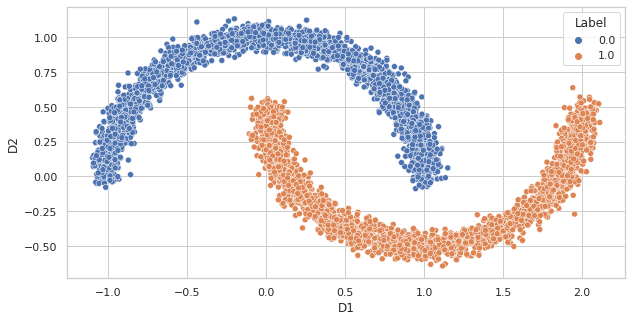

In [6]:
LR1.Scatter_plot(arg)

In [ ]:
LR1.fit(arg,method =None)

		Table Stats for Method :  None
+----+---------------------+-----------------+-----------------------+-------------------+--------+
|    |   Training Accuracy |   Training Loss |   Validation Accuracy |   Validation Loss |   Fold |
|----+---------------------+-----------------+-----------------------+-------------------+--------|
|  0 |            0.891223 |        0.237534 |              0.888112 |          0.246443 |      1 |
|  1 |            0.889722 |        0.237032 |              0.89011  |          0.248407 |      2 |
|  2 |            0.889472 |        0.241105 |              0.893107 |          0.231707 |      3 |
|  3 |            0.889972 |        0.241996 |              0.893107 |          0.22816  |      4 |
|  4 |            0.891359 |        0.238136 |              0.886546 |          0.243577 |      5 |
+----+---------------------+-----------------+-----------------------+-------------------+--------+
		Curves representing Training statistics and Validation statistics

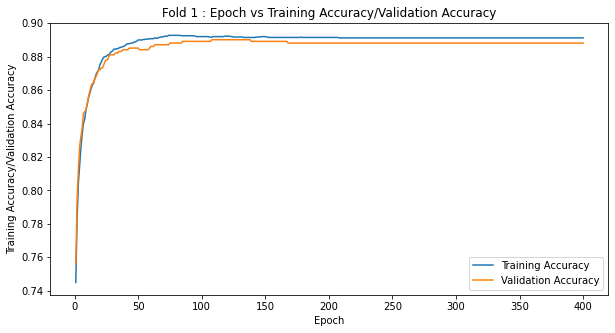

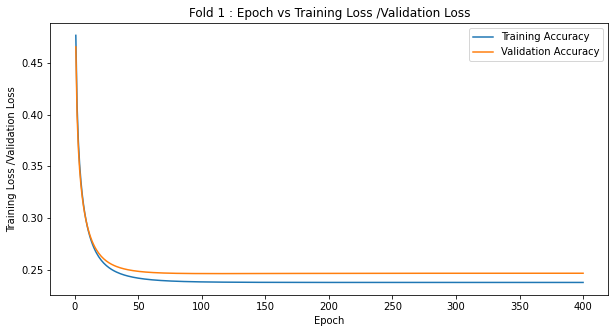

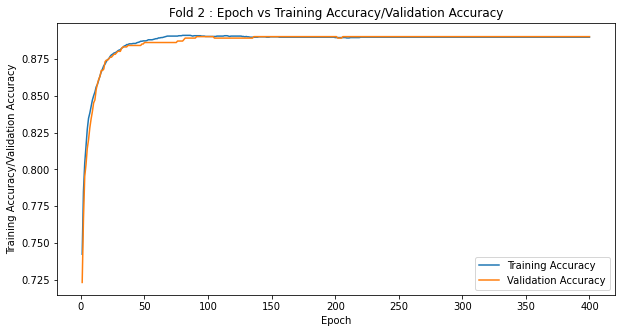

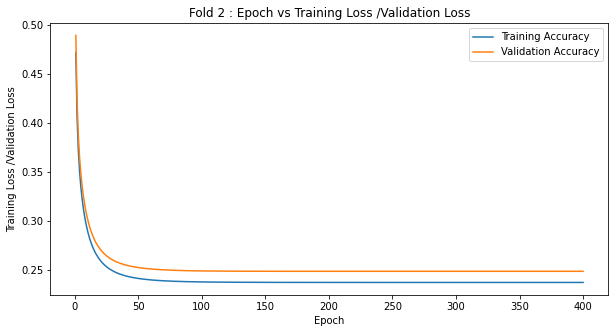

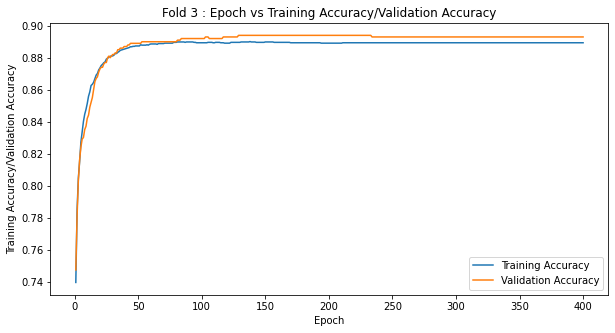

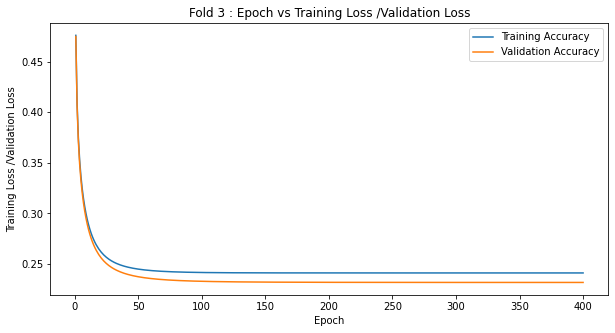

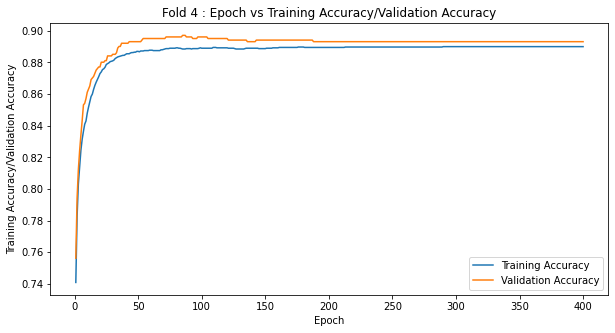

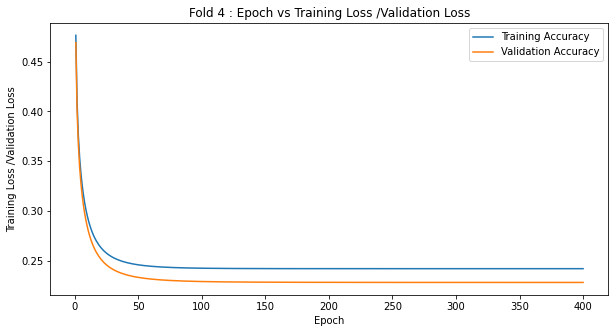

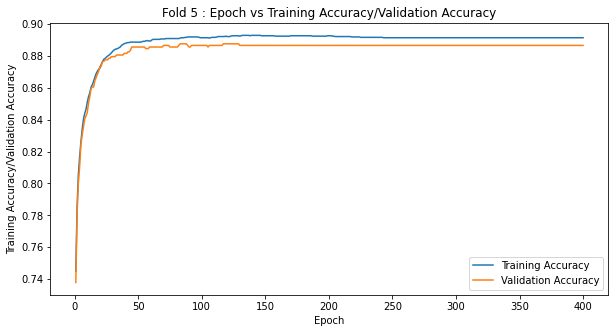

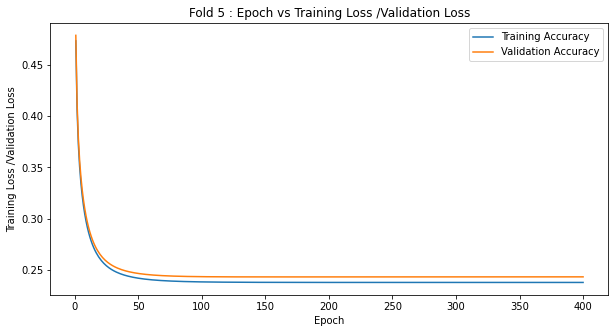

In [ ]:
LR1.loadsaved(arg,method =None,plot=True,print_table=True)

In [ ]:
LR1.Regularization(arg)

Optimal Value of regularization constant :  0.0001
			Table Stats for optimal value of regularization constant : 
+----+---------------------+-----------------+-----------------------+-------------------+--------+
|    |   Training Accuracy |   Training Loss |   Validation Accuracy |   Validation Loss |   Fold |
|----+---------------------+-----------------+-----------------------+-------------------+--------|
|  0 |            0.891223 |        0.237534 |              0.888112 |          0.246443 |      1 |
|  1 |            0.889722 |        0.237032 |              0.89011  |          0.248407 |      2 |
|  2 |            0.889472 |        0.241105 |              0.893107 |          0.231707 |      3 |
|  3 |            0.889972 |        0.241996 |              0.893107 |          0.22816  |      4 |
|  4 |            0.891359 |        0.238136 |              0.886546 |          0.243577 |      5 |
+----+---------------------+-----------------+-----------------------+----------------

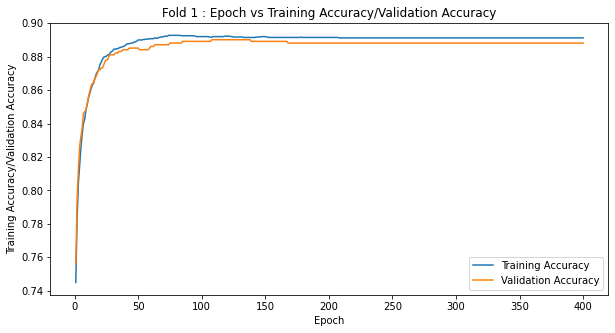

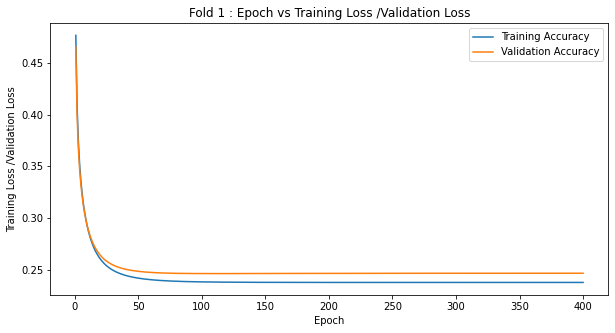

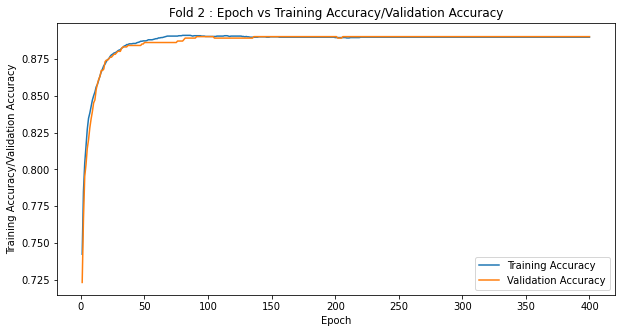

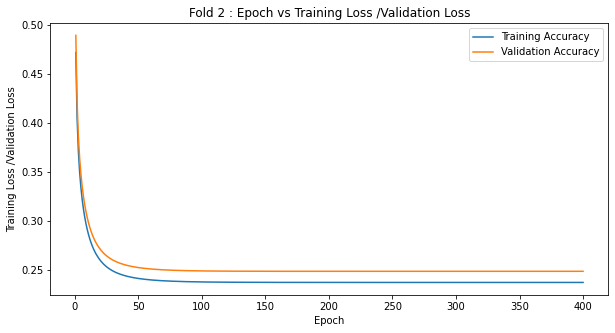

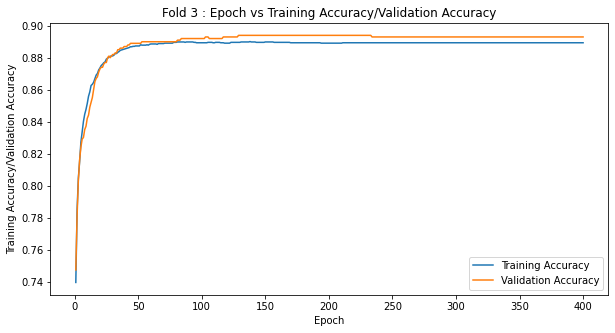

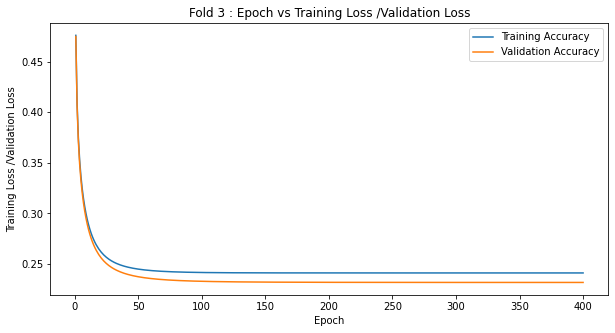

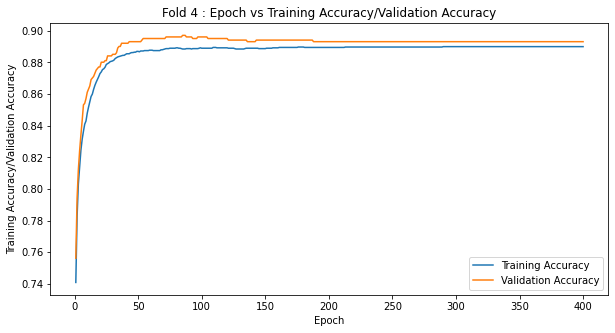

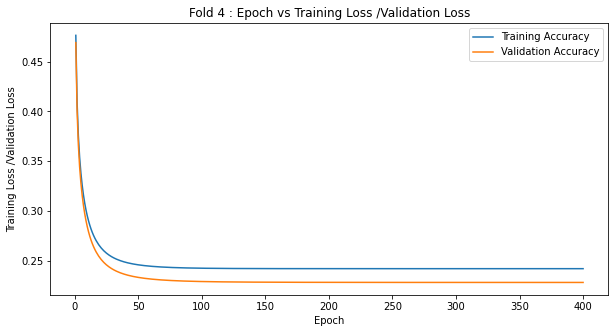

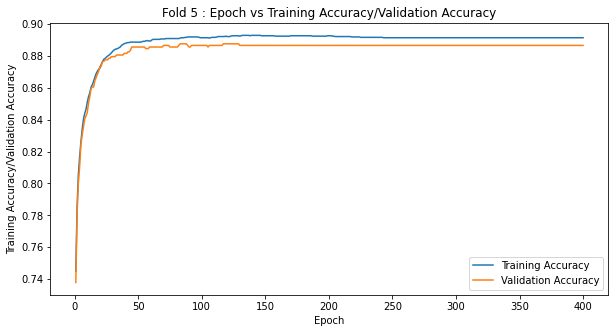

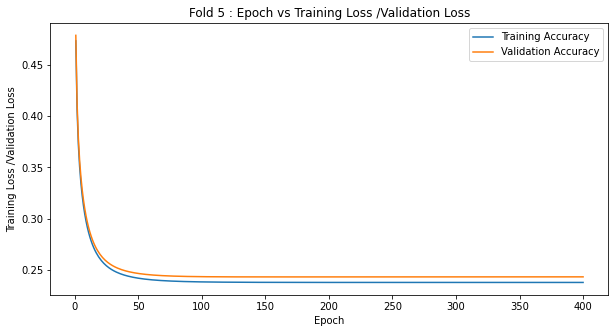

In [ ]:
LR1.LoadReg(arg)

In [ ]:
LR1.Predefined(arg)

In [ ]:
LR1.loadpredefined(arg) 

			Table Stats for Simple Logistic Regression using Sklearn : 
+----+--------+---------------------+-----------------+-----------------+-------------+
|    |   Fold |   Training Accuracy |   Training Loss |   Test Accuracy |   Test Loss |
|----+--------+---------------------+-----------------+-----------------+-------------|
|  0 |      1 |            0.891223 |        0.237534 |        0.888112 |    0.246449 |
|  1 |      2 |            0.889722 |        0.237032 |        0.89011  |    0.248408 |
|  2 |      3 |            0.889472 |        0.241105 |        0.893107 |    0.231703 |
|  3 |      4 |            0.889972 |        0.241996 |        0.893107 |    0.228158 |
|  4 |      5 |            0.891359 |        0.238136 |        0.886546 |    0.243579 |
+----+--------+---------------------+-----------------+-----------------+-------------+

Optimal Value of regularization constant 0.0001
			Table Stats for Optimal Value of regularization constant :
+----+--------+-------------------

In [ ]:
# For Question 3
path2  = "/content/drive/My Drive/Projects/ML_Assignment/ML_Assignment_2/Assignment_2_datasets/dataset_2.mat"
split2 = 5
epochs2 = 400
learning2 = 0.0001     # lr = 0.0001 , epoch = 400 for max acc in ovr
reg2 = [0]
arg = [path2,split2,epochs2,learning2,None,None,reg2]

#Class Object
LR2 =  LogRegression(arg)

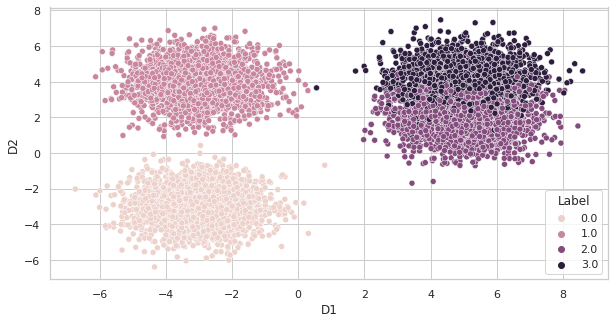

In [ ]:
LR2.Scatter_plot(arg)

In [ ]:
LR2.fit(arg,method='ovo' , reg = 0.0001)

In [ ]:
LR2.loadsaved(arg,method ='ovo',print_table=True,print_class=True)

		Table Stats for Method :  ovo
+----+--------+---------------------+--------------------+
|    |   Fold |   Training Accuracy |   Testing Accuracy |
|----+--------+---------------------+--------------------|
|  0 |      1 |            0.896612 |           0.895052 |
|  1 |      2 |            0.896237 |           0.887056 |
|  2 |      3 |            0.895862 |           0.898551 |
|  3 |      4 |            0.892862 |           0.898051 |
|  4 |      5 |            0.895302 |           0.897796 |
+----+--------+---------------------+--------------------+
	Classwise Accuracy of Training for Method :  ovo
+----+--------+----------+-------+----------+----------+
|    |   Fold |      0.0 |   1.0 |      2.0 |      3.0 |
|----+--------+----------+-------+----------+----------|
|  0 |      1 | 0.940737 |     1 | 0.830458 | 0.817727 |
|  1 |      2 | 0.940822 |     1 | 0.835926 | 0.80663  |
|  2 |      3 | 0.948058 |     1 | 0.831055 | 0.80557  |
|  3 |      4 | 0.931795 |     1 | 0.828086 |

In [ ]:
LR2.fit(arg,method='ovr' , reg = 0.0001)

In [ ]:
LR2.loadsaved(arg,method ='ovr',print_table=True,print_class=True)

		Table Stats for Method :  ovr
+----+--------+---------------------+--------------------+
|    |   Fold |   Training Accuracy |   Testing Accuracy |
|----+--------+---------------------+--------------------|
|  0 |      1 |            0.912739 |           0.916042 |
|  1 |      2 |            0.915864 |           0.912544 |
|  2 |      3 |            0.910489 |           0.913543 |
|  3 |      4 |            0.912739 |           0.910045 |
|  4 |      5 |            0.916542 |           0.916333 |
+----+--------+---------------------+--------------------+
	Classwise Accuracy of Training for Method :  ovr
+----+--------+-------+-------+----------+----------+
|    |   Fold |   0.0 |   1.0 |      2.0 |      3.0 |
|----+--------+-------+-------+----------+----------|
|  0 |      1 |     1 |     1 | 0.908329 | 0.743615 |
|  1 |      2 |     1 |     1 | 0.903663 | 0.758413 |
|  2 |      3 |     1 |     1 | 0.913574 | 0.727089 |
|  3 |      4 |     1 |     1 | 0.904548 | 0.748012 |
|  4 |   

In [ ]:
LR2.Predefined(arg,method='ovo',lamb = 0.0001) 

In [ ]:
LR2.loadpredefined(arg,method='ovo') 

		Table Stats for Method :  ovo
+----+--------+---------------------+-----------------+
|    |   Fold |   Training Accuracy |   Test Accuracy |
|----+--------+---------------------+-----------------|
|  0 |      1 |            0.923865 |        0.927036 |
|  1 |      2 |            0.925866 |        0.921539 |
|  2 |      3 |            0.922365 |        0.933533 |
|  3 |      4 |            0.926116 |        0.92004  |
|  4 |      5 |            0.926287 |        0.925351 |
+----+--------+---------------------+-----------------+
	Classwise Accuracy of Training for Method :  ovo
+----+--------+-------+-------+----------+----------+
|    |   Fold |   0.0 |   1.0 |      2.0 |      3.0 |
|----+--------+-------+-------+----------+----------|
|  0 |      1 |     1 |     1 | 0.847215 | 0.850275 |
|  1 |      2 |     1 |     1 | 0.846463 | 0.855851 |
|  2 |      3 |     1 |     1 | 0.847168 | 0.844051 |
|  3 |      4 |     1 |     1 | 0.849075 | 0.856362 |
|  4 |      5 |     1 |     1 | 0.84

In [ ]:
LR2.Predefined(arg,method='ovr',lamb = 0.0001) 

In [ ]:
LR2.loadpredefined(arg,method='ovr') 

		Table Stats for Method :  ovr
+----+--------+---------------------+-----------------+
|    |   Fold |   Training Accuracy |   Test Accuracy |
|----+--------+---------------------+-----------------|
|  0 |      1 |            0.923115 |        0.924538 |
|  1 |      2 |            0.924491 |        0.92004  |
|  2 |      3 |            0.920365 |        0.929535 |
|  3 |      4 |            0.925116 |        0.917541 |
|  4 |      5 |            0.924163 |        0.924349 |
+----+--------+---------------------+-----------------+
	Classwise Accuracy of Training for Method :  ovr
+----+--------+-------+-------+----------+----------+
|    |   Fold |   0.0 |   1.0 |      2.0 |      3.0 |
|----+--------+-------+-------+----------+----------|
|  0 |      1 |     1 |     1 | 0.843273 | 0.851277 |
|  1 |      2 |     1 |     1 | 0.84295  | 0.853842 |
|  2 |      3 |     1 |     1 | 0.841797 | 0.841519 |
|  3 |      4 |     1 |     1 | 0.841079 | 0.860338 |
|  4 |      5 |     1 |     1 | 0.83